<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import pydicom" || pip install pydicom
!python -c "import dicom2nifti" ||pip install dicom2nifti



from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from google.colab import drive


2024-01-09 09:44:51.358716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 09:44:51.358804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 09:44:51.366287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 09:44:53.943295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/PET_data/ASC-PET-001'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set dataset path

In [25]:

train_images = sorted(glob.glob(os.path.join(root_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(root_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# making  smaller input to save time for practing stage:
# train_files, val_files =  data_dicts[:1], data_dicts[-1:]
train_files, val_files =  data_dicts[-1:], data_dicts[-1:]

set_determinism(seed=0)


In [4]:
print(len(data_dicts))
print(len(train_files))
print(len(val_files))

184
1
1


In [26]:
from monai.transforms import LoadImage

# Function to load an image and print its size
def print_image_size(file_info):
    loader = LoadImage(image_only=True)
    image = loader(file_info['image'])
    print(f"Image size: {image.shape}")

# Print sizes of the last few images in the train_files
print("Train Files:")
for file_info in train_files:  # Adjust the number as needed
    print_image_size(file_info)

# Print sizes of the last few images in the val_files
print("\nValidation Files:")
for file_info in val_files:  # Adjust the number as needed
    print_image_size(file_info)



Train Files:
Image size: torch.Size([180, 180, 317])

Validation Files:
Image size: torch.Size([180, 180, 317])


In [32]:
# import nibabel as nib

# def print_axial_pixel_size_nifti(file_path):
#     # Load the NIfTI file
#     nifti_img = nib.load(file_path)
#     header = nifti_img.header

#     # Extract pixel spacing (usually in the 'pixdim' field of the header)
#     # pixdim[1], pixdim[2], and pixdim[3] correspond to x, y, and z dimensions, respectively
#     spacing = header.get_zooms()
#     axial_spacing = spacing[:2]  # Get spacing for x and y dimensions (axial plane)
#     print(f"Image: {file_path}, Axial pixel size (x, y): {axial_spacing}")

# # Print axial pixel sizes for the first few images in train_files
# print("Axial Pixel Sizes in Training Data:")
# for file_info in train_files[:5]:  # Adjust the number as needed
#     file_path = file_info['image']
#     print_axial_pixel_size_nifti(file_path)

Axial Pixel Sizes in Training Data:
Image: /content/drive/My Drive/PET_data/ASC-PET-001/NAC/001404_C1_RZ_.nii.gz, Axial pixel size (x, y): (4.07283, 4.07283)
Image: /content/drive/My Drive/PET_data/ASC-PET-001/NAC/001405_C1_RZ_.nii.gz, Axial pixel size (x, y): (4.07283, 4.07283)
Image: /content/drive/My Drive/PET_data/ASC-PET-001/NAC/001406_C1_RZ_.nii.gz, Axial pixel size (x, y): (4.07283, 4.07283)
Image: /content/drive/My Drive/PET_data/ASC-PET-001/NAC/001407_C1_RZ_.nii.gz, Axial pixel size (x, y): (4.07283, 4.07283)
Image: /content/drive/My Drive/PET_data/ASC-PET-001/NAC/001410_C1_RZ_.nii.gz, Axial pixel size (x, y): (4.07283, 4.07283)


In [27]:
#### My method

crop_size = (180, 180, 32)  # Adjusted based on my data

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # ScaleIntensityRanged(keys=["image", "target"],a_min=-60, a_max=120, b_min=0.0, b_max=1.0, clip=True),
        # Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode='bilinear'),
        # CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),
    ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # ScaleIntensityRanged(keys=["image", "target"],a_min=-60, a_max=120, b_min=0.0, b_max=1.0, clip=True),
        # Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode=('bilinear')),
        # CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),

    ])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)



Loading dataset: 100%|██████████| 1/1 [00:30<00:00, 30.52s/it]


image shape: torch.Size([180, 180, 32]), target shape: torch.Size([180, 180, 32])


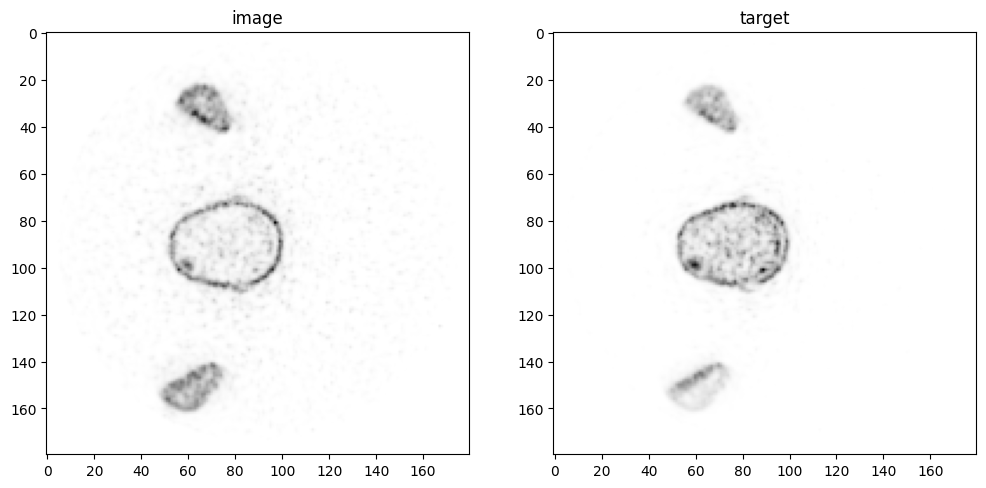

In [18]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 31

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

In [19]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break

Batch 0 image size: torch.Size([1, 1, 180, 180, 32])


# **Create Model, Loss, Optimizer**

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [29]:
###### MY method
max_epochs = 50
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (batch_data["image"].to(device),
                           batch_data["target"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (val_data["image"].to(device),
                                           val_data["target"].to(device),)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            print(f"Validation loss: {val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_PET.pth"))
                print("Saved new best metric model")

print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


----------
epoch 1/50
1/0, train_loss: 0.9743
epoch 1 average loss: 0.9743
----------
epoch 2/50
1/0, train_loss: 0.9094
epoch 2 average loss: 0.9094
Validation loss: 0.7669
Saved new best metric model
----------
epoch 3/50
1/0, train_loss: 0.8597
epoch 3 average loss: 0.8597
----------
epoch 4/50
1/0, train_loss: 0.8210
epoch 4 average loss: 0.8210
Validation loss: 0.7659
Saved new best metric model
----------
epoch 5/50
1/0, train_loss: 0.7910
epoch 5 average loss: 0.7910
----------
epoch 6/50
1/0, train_loss: 0.7675
epoch 6 average loss: 0.7675
Validation loss: 0.7662
----------
epoch 7/50
1/0, train_loss: 0.7479
epoch 7 average loss: 0.7479
----------
epoch 8/50
1/0, train_loss: 0.7311
epoch 8 average loss: 0.7311
Validation loss: 0.7672
----------
epoch 9/50
1/0, train_loss: 0.7166
epoch 9 average loss: 0.7166
----------
epoch 10/50
1/0, train_loss: 0.7039
epoch 10 average loss: 0.7039
Validation loss: 0.7680
----------
epoch 11/50
1/0, train_loss: 0.6924
epoch 11 average loss: 0.

train completed, best_metric: 0.5148 at epoch: 50


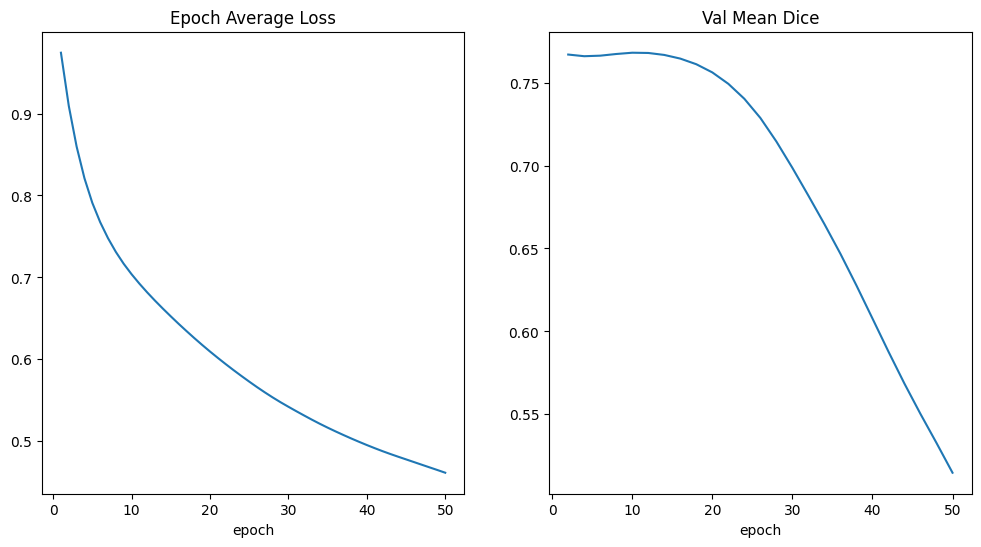

In [30]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

100%|██████████| 1/1 [00:16<00:00, 16.67s/it]


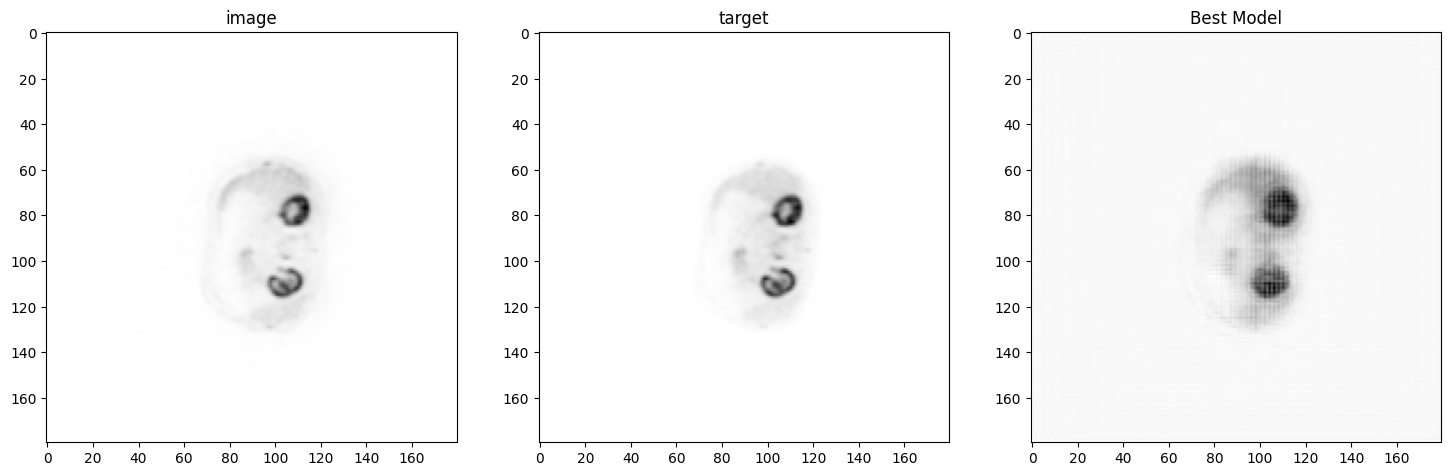

In [31]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.80) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_PET.pth")))
model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 15
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break


